## Sección de Librerías

In [2]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [3]:
assets = pd.read_csv('Indices/tickers_nasdaq100.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [4]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  94 of 94 completed


In [5]:
prices.tail()

,ABNB,ADBE,ADI,ADSK,AEP,ALGN,AMAT,AMD,AMGN,ANSS,...,TMUS,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZM,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-22,127.959999,477.579987,186.110001,206.699997,85.099998,334.399994,138.919998,110.699997,229.660004,325.679993,...,134.339996,172.630005,228.009995,348.160004,31.889999,12.0900,221.000000,62.759998,67.449997,144.839996
2023-06-23,124.730003,484.720001,185.940002,202.000000,83.489998,328.829987,136.070007,110.010002,227.110001,319.540009,...,132.800003,167.679993,224.350006,347.000000,31.400000,11.7900,222.250000,62.099998,66.620003,142.699997
2023-06-26,123.129997,479.510010,186.339996,200.779999,83.779999,331.459991,139.800003,107.510002,224.729996,316.200012,...,134.850006,168.750000,223.000000,347.450012,31.590000,11.7800,219.940002,62.860001,66.620003,141.710007
2023-06-27,127.889999,489.269989,192.380005,206.850006,83.440002,340.690002,146.550003,110.389999,222.610001,323.320007,...,136.169998,176.309998,224.630005,347.119995,28.639999,12.2700,224.220001,62.439999,68.050003,144.660004
2023-06-28,128.850006,484.109985,189.970001,204.255905,81.970001,342.420013,144.107300,109.680000,219.990005,322.260010,...,135.600006,175.289993,222.949997,350.864990,28.455000,12.2393,224.304993,61.378399,67.940002,143.210007


In [6]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 91/91 [00:12<00:00,  7.55it/s]


,exp_risk,exp_return,esg_score
NXPI,0.400080,0.004033,0.216
NFLX,0.575069,0.105633,0.163
MU,0.428034,0.105832,0.174
MSFT,0.303918,-0.118641,0.152
MRVL,0.580700,-0.016848,0.201
...,...,...,...
DLTR,0.392582,-0.193019,0.149
CTSH,0.296101,0.035722,0.144
CTAS,0.240665,-0.136951,0.183
CSX,0.254356,-0.038031,0.201


In [7]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

70it [00:00, 17491.88it/s]


,exp_risk,exp_return
ON,0.530947,-0.433318
ORLY,0.251180,-0.257684
PANW,0.425619,-0.347157
VRTX,0.276535,-0.287092
PEP,0.167558,-0.139061
PCAR,0.250014,-0.190821
AVGO,0.328814,-0.319953
EXC,0.221494,-0.145062


In [8]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets)

## Segunda Parte, Definición del Problema

In [9]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


In [10]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [11]:
eps = np.array([0.01,0.01])
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']

### Con pesos uniformes

In [17]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=8)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


6435it [00:00, 20233.90it/s]
6435it [00:01, 5037.34it/s]

Total (6435, 2)
Mejores (93, 2)
Eps-Mejores (1731, 2)


In [18]:
frames = [FA_das, FA_das_best_eps, FA_das_best]
labels = ['All (Das-Dennis)', 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

### Con Algoritmos Evolutivos

In [19]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=20,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=20, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [20]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

6000it [00:00, 16768.83it/s]
6000it [00:03, 1896.32it/s]

Total (6000, 2)
Mejores (392, 2)
Eps-Mejores (5140, 2)


In [21]:
frames = [FA_nsgaii, FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['All (NSGA-II)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

#### Con SMS-EMOA

In [22]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

6000it [00:00, 11385.19it/s]
6000it [00:03, 1976.99it/s]

Total (6000, 2)
Mejores (991, 2)
Eps-Mejores (5457, 2)


In [23]:
frames = [FA_smsemoa, FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

## Evaluación 

In [24]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  parameter): 
    if name=='das-dennis':
        X_ = get_reference_directions("das-dennis", len(PROFITS), n_partitions=parameter)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_das)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, parameter, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    return FA_best.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = { 'das-dennis': 8, 'nsgaii': nsgaii, 'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator]=np.mean( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())
     


In [25]:
evaluation = full_evaluation(10, algs, ef_R, np.array([1.1,1.1]))
evaluation

6435it [00:00, 24101.62it/s]
6000it [00:00, 14962.69it/s]
6000it [00:00, 11560.87it/s]
6435it [00:00, 25740.96it/s]
6000it [00:00, 17192.39it/s]
6000it [00:00, 9508.82it/s] 
6435it [00:00, 28203.49it/s]
6000it [00:00, 14700.05it/s]
6000it [00:00, 9892.15it/s] 
6435it [00:00, 19381.97it/s]
6000it [00:00, 18072.96it/s]
6000it [00:00, 10016.59it/s]
6435it [00:00, 28987.50it/s]
6000it [00:00, 13273.88it/s]
6000it [00:00, 8343.22it/s] 
6435it [00:00, 25740.56it/s]
6000it [00:00, 16620.50it/s]
6000it [00:00, 8972.98it/s] 
6435it [00:00, 24741.18it/s]
6000it [00:00, 12390.83it/s]
6000it [00:00, 10067.28it/s]
6435it [00:00, 26481.95it/s]
6000it [00:00, 15373.31it/s]
6000it [00:00, 8374.58it/s] 
6435it [00:00, 23486.39it/s]
6000it [00:00, 13374.55it/s]
6000it [00:00, 8955.29it/s] 
6435it [00:00, 28472.78it/s]
6000it [00:00, 16620.18it/s]
6000it [00:00, 10291.76it/s]


,GD,IGD,HV
das-dennis,0.003125,0.006126,0.905429
nsgaii,0.002096,0.004023,0.917081
sms-emoa,0.001639,0.004398,0.918688


## Gráficas de Interés Muestreo Ganador

In [26]:
X, F, ESG =pymoo_extras.get_weights_with_pymoo(portfolio_problem,smsemoa, termination)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

6000it [00:00, 10886.19it/s]
6000it [00:03, 1642.44it/s]
5490it [00:00, 5873.51it/s] 

Total (6000, 2)
Mejores (930, 2)
Eps-Mejores (5490, 2)
Mejores 3D (1635, 3)


In [27]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

In [28]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [29]:
fig = px.scatter_3d(FA_3D.sort_values(by='Type'), x='exp_risk', y='exp_return', z='exp_esg',
                color_discrete_sequence=['rgb(27,158, 119)','rgb(141,160,203)'],
                color='Type', width=800, height=800, 
                labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
fig.show()

In [30]:
fig = px.scatter(FA_3D_best, x='exp_risk', y='exp_return', color='exp_esg',
                 labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.add_trace(go.Scatter(x=ef_R[:,0], y=ef_R[:,1],
                    mode='lines',
                    name='Markowitz', 
                    marker_color='#222A2A'), 
                 )
fig.update_layout(coloraxis_colorbar_y=0.45)
fig.show()

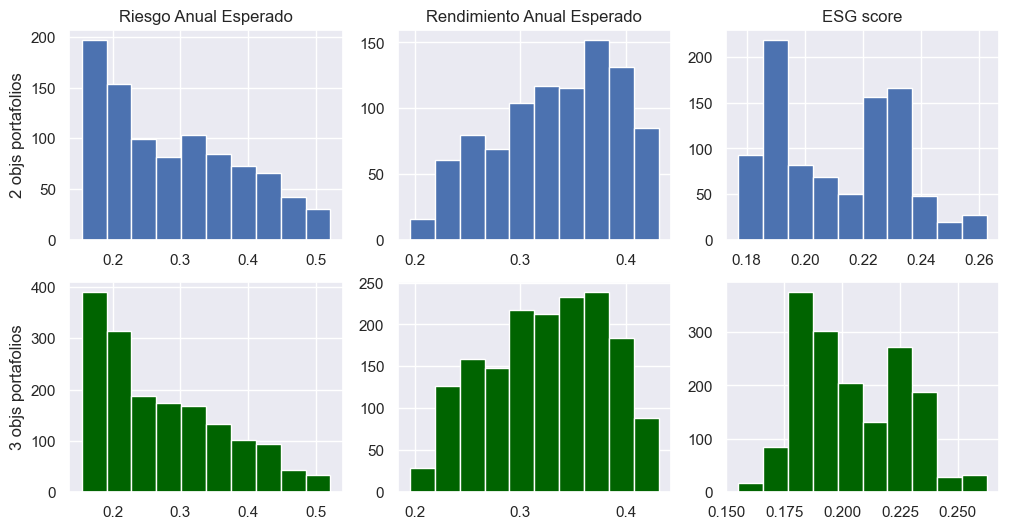

In [31]:
fig, ax = plt.subplots(2,3, figsize= (12,6))
ax[0][0].set_ylabel('2 objs portafolios')
ax[1][0].set_ylabel('3 objs portafolios')
ax[0][0].set_title('Riesgo Anual Esperado')
ax[0][1].set_title('Rendimiento Anual Esperado')
ax[0][2].set_title('ESG score')
for i in range(3): 
    FA_best.iloc[:, i].hist(ax=ax[0][i])
    FA_3D_best.iloc[:, i].hist(ax=ax[1][i], color='darkgreen')


In [32]:
X_best = X[FA_best.index]
X_3D_best = X[FA_3D_best.index]
X_best_means = np.mean(X_best, axis=0)
X_3D_best_means = np.mean(X_3D_best, axis=0)


In [33]:
assets_proportion = assets_info.loc[best_assets.index]
assets_proportion['Aportacion 2obj']= X_best_means 
assets_proportion['Aportacion 3obj']= X_3D_best_means

Text(0.5, 1.0, 'Composición de Portafolios 3 objs')

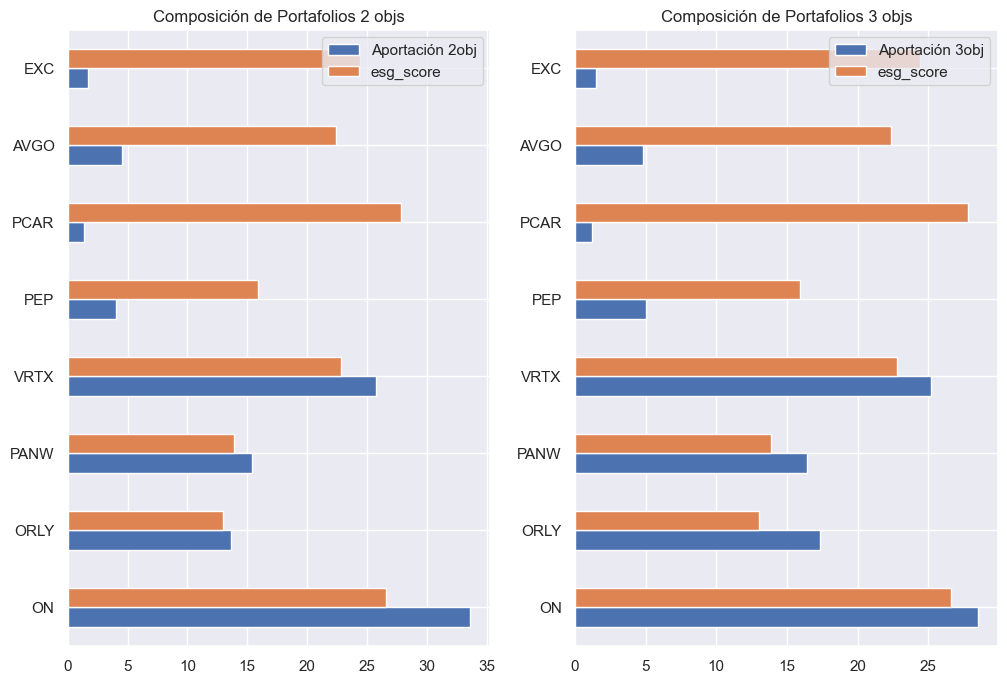

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
(assets_proportion[['Aportacion 2obj','esg_score']]*100).plot(kind='barh', ax=ax[0])
(assets_proportion[['Aportacion 3obj','esg_score']]*100).plot(kind='barh', ax=ax[1])
ax[0].set_title('Composición de Portafolios 2 objs')
ax[1].set_title('Composición de Portafolios 3 objs')